In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

In [2]:
data_path = '/kaggle/input/potato-diseases-datasets'

In [3]:
classes = os.listdir(data_path)

class_images = {}

for i in classes:
    
    class_images[i] = random.sample(os.listdir(os.path.join(data_path, i)), 5)

In [4]:
class_images

{'Black Scurf': ['55.jpg', '36.jpg', '10.jpg', '29.jpg', '53.jpg'],
 'Blackleg': ['38.jpg', '51.jpg', '39.jpg', '44.jpg', '12.jpg'],
 'Common Scab': ['26.jpg', '2.jpg', '17.jpg', '38.jpg', '48.jpg'],
 'Pink Rot': ['50.jpg', '22.jpg', '43.jpg', '54.jpg', '10.jpg'],
 'Dry Rot': ['31.jpg', '20.jpg', '1.jpg', '7.jpg', '50.jpg'],
 'Miscellaneous': ['35.jpg', '3.jpg', '59.jpg', '32.jpg', '63.jpg'],
 'Healthy Potatoes': ['26.jpg', '67.jpg', '50.jpg', '37.jpg', '51.jpg']}

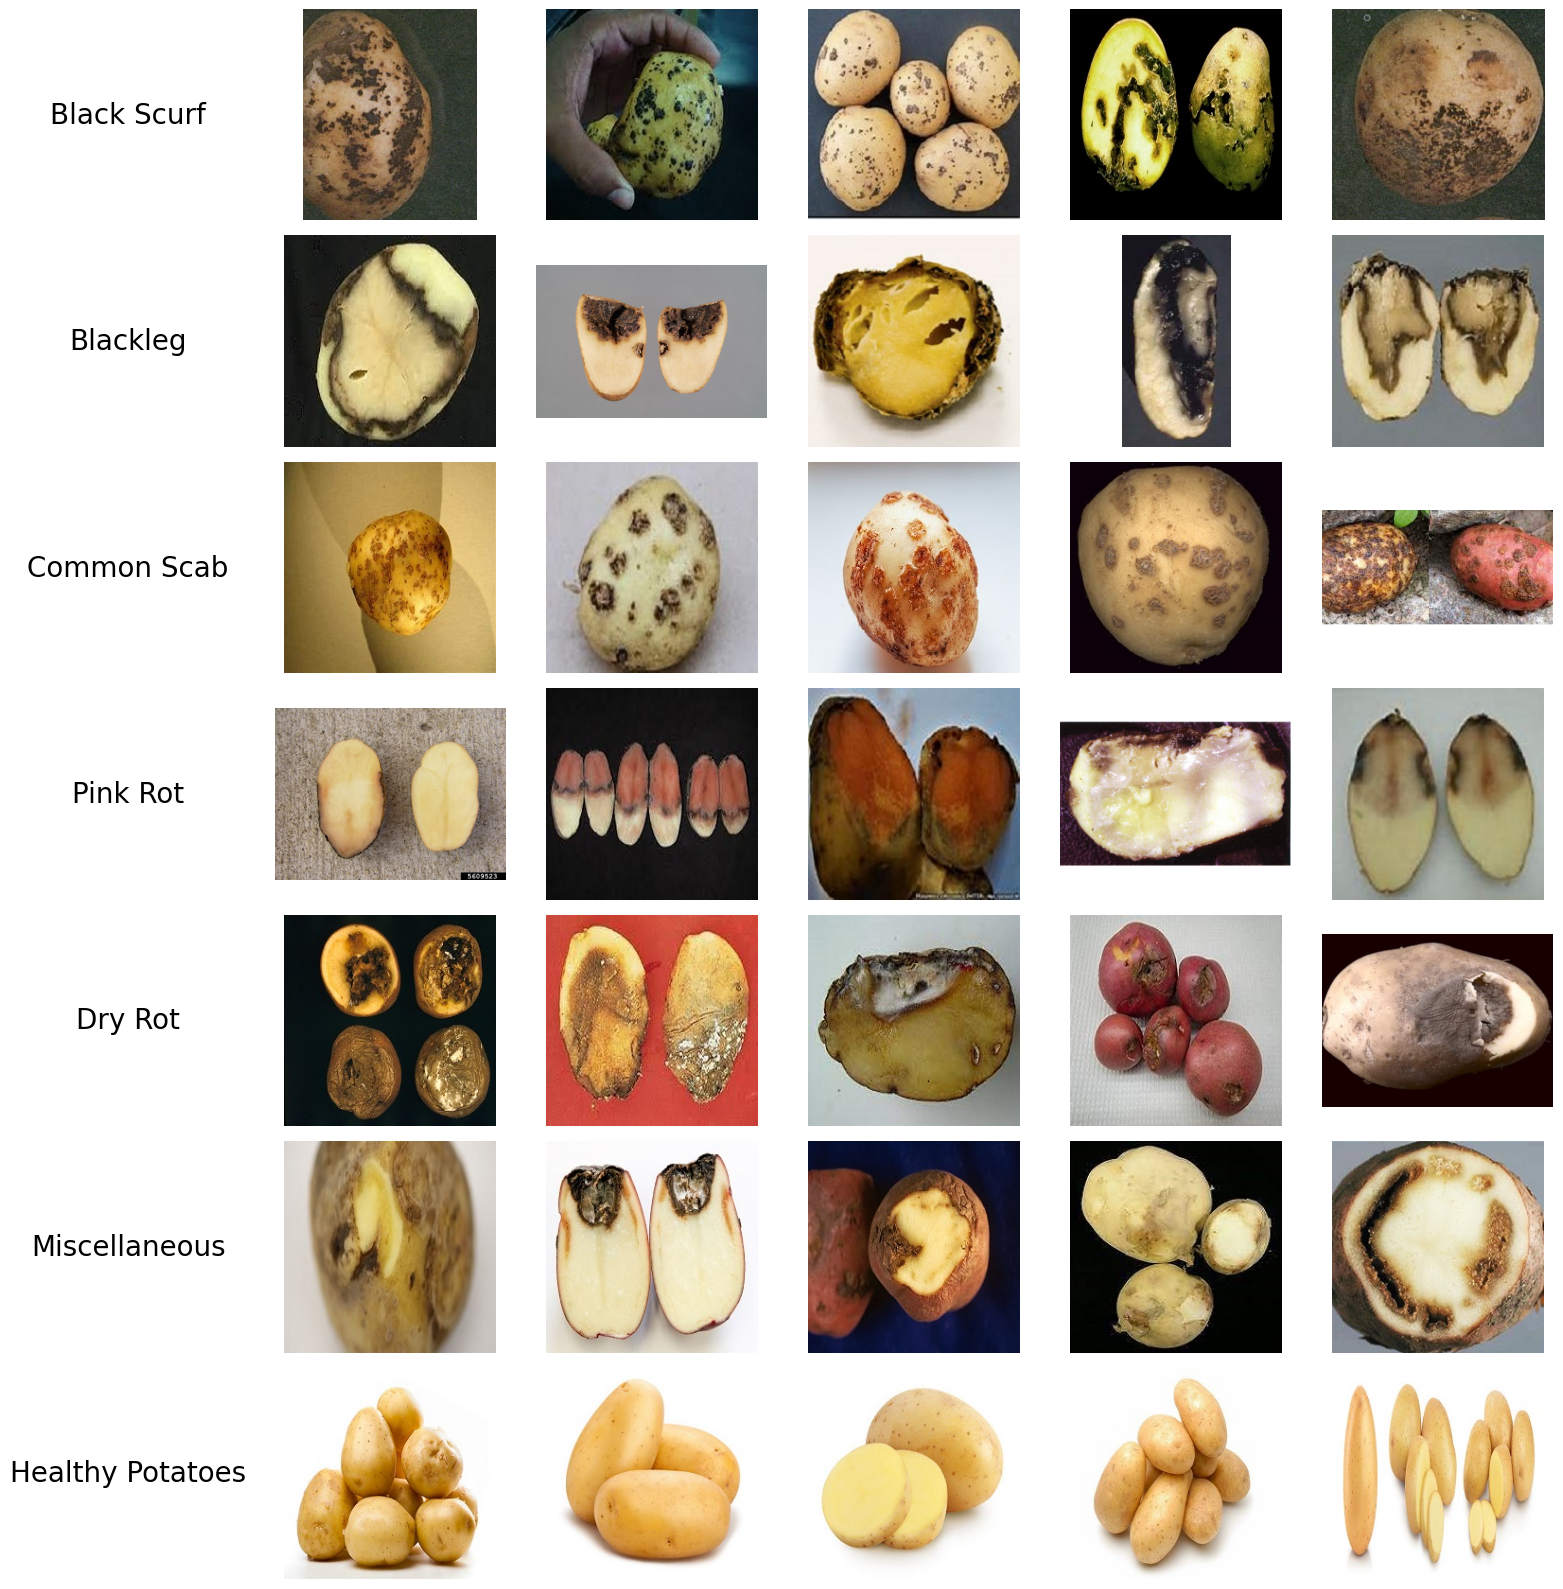

In [5]:
fig, ax = plt.subplots(7, 6, figsize=(16, 16))

# Loop through each class and its images
for i, class_name in enumerate(class_images):
    
    # Display the class name before each row
    ax[i, 0].text(0.5, 0.5, class_name, fontsize=20, ha='center', va='center', transform=ax[i, 0].transAxes)
    ax[i, 0].axis('off')
    
    for j, file in enumerate(class_images[class_name]):
        # Load and display the image
        image = cv2.imread(os.path.join(data_path, class_name, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i, j + 1].imshow(image)
        ax[i, j + 1].axis('off')
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
# Check number of images in each class

for i in os.listdir(data_path):
    
    length = len(os.listdir(os.path.join(data_path, i)))
    
    print('{} = {} Images'.format(i, length))
    print()

Black Scurf = 58 Images

Blackleg = 60 Images

Common Scab = 62 Images

Pink Rot = 57 Images

Dry Rot = 60 Images

Miscellaneous = 74 Images

Healthy Potatoes = 80 Images



In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
data_transforms = transforms.Compose([
    
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

In [10]:
path = '/kaggle/input/potato-diseases-datasets'

image_datasets = datasets.ImageFolder(path, data_transforms)

train_size = int(0.8 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_datasets, test_datasets = torch.utils.data.random_split(image_datasets, [train_size, test_size])

In [11]:
dataloader = {}

dataloader['train'] = DataLoader(train_datasets, batch_size = 4, shuffle= True, num_workers = 4)
dataloader['test'] = DataLoader(test_datasets, batch_size = 4, shuffle= True, num_workers = 4)

In [12]:
dataset_sizes = {}

dataset_sizes['train'] = len(train_datasets)
dataset_sizes['test'] = len(test_datasets)

In [13]:
class_names = image_datasets.classes

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            if epoch%10 == 0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)
            
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                if epoch%10 == 0:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    print()

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_ft = models.mobilenet_v2(pretrained='True')
num_ftrs = model_ft.classifier[1].in_features

model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 183MB/s]


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 3.7585 Acc: 0.3056

test Loss: 2.9255 Acc: 0.3626

Epoch 10/199
----------
train Loss: 0.9652 Acc: 0.6444

test Loss: 1.1413 Acc: 0.6264

Epoch 20/199
----------
train Loss: 0.8635 Acc: 0.6944

test Loss: 0.8805 Acc: 0.7033

Epoch 30/199
----------
train Loss: 0.8732 Acc: 0.6861

test Loss: 0.9962 Acc: 0.6813

Epoch 40/199
----------
train Loss: 0.7995 Acc: 0.7333

test Loss: 0.9042 Acc: 0.7143

Epoch 50/199
----------
train Loss: 0.8203 Acc: 0.7333

test Loss: 0.8472 Acc: 0.7253

Epoch 60/199
----------
train Loss: 0.9032 Acc: 0.7000

test Loss: 0.8656 Acc: 0.7033

Epoch 70/199
----------
train Loss: 0.8151 Acc: 0.7139

test Loss: 1.0093 Acc: 0.7363

Epoch 80/199
----------
train Loss: 0.8808 Acc: 0.7000

test Loss: 0.8251 Acc: 0.7253

Epoch 90/199
----------
train Loss: 0.8206 Acc: 0.7000

test Loss: 1.0048 Acc: 0.6703

Epoch 100/199
----------
train Loss: 0.8778 Acc: 0.7222

test Loss: 0.8679 Acc: 0.7033

Epoch 110/199
----------
train Loss: 0.8101

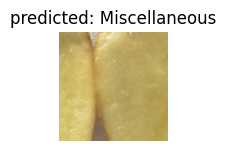

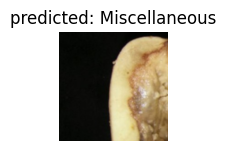

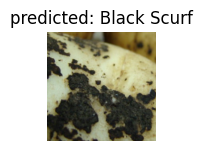

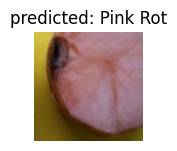

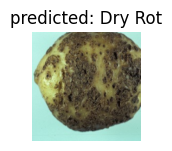

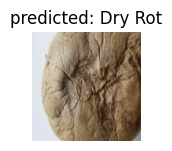

In [18]:
visualize_model(model_ft)

plt.ioff()
plt.show()